In [1]:
pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install sklearn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install fastText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!git clone https://github.com/facebookresearch/fastText.git
!cd fastText
!pip install fastText
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
# model = fasttext.load_model('cc.en.300.bin')

fatal: destination path 'fastText' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'cc.en.300.bin'

In [7]:
from sklearn import metrics
import pandas as pd
import os
import nltk
from sklearn.model_selection import GridSearchCV
import numpy as np
from nltk.corpus import stopwords
from autocorrect import Speller
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from transformers import TFBertTokenizer
from tqdm import tqdm
import spacy
import re
from nltk.tokenize import word_tokenize
nlp = spacy.load('en_core_web_sm')
import torch
import torch.nn as nn
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import sentence_transformers
from sklearn.svm import SVC
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tqdm import tqdm
import fastText as ft
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
#evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report

## NON-CONTEXTUALIZED EMBEDDINGS

In [10]:
train = pd.read_json('/content/train.jsonl', lines = True)
dev = pd.read_json('/content/val.jsonl',lines = True)
test = pd.read_json('/content/test.jsonl', lines = True)

In [11]:
train

,id,image,title,label
0,211,img/depression_211.jpg,Depressed black man sitting outdoor. Stock Photo,1
1,1226,img/depression_1226.jpg,Asian man feels sad on bed looking and focus o...,1
2,1548,img/joy_1548.jpg,Portrait of happy excited positive cheerful te...,0
3,582,img/depression_582.jpg,Unrecognizable young Asian man overwhelmed by ...,1
4,1277,img/joy_1277.jpg,Child wearing red rain boots jumping into a pu...,0
...,...,...,...,...
4375,1550,img/joy_1550.jpg,Silhouette young man jumping on the mountain a...,0
4376,297,img/joy_297.jpg,Funny kid girl playing outdoor surprised emoti...,0
4377,1167,img/sadness_1167.jpg,Depressed sad pensive millennial african ameri...,1
4378,732,img/happiness_732.jpg,Successful company with happy workers Stock Photo,0


In [12]:
model = fasttext.load_model('cc.en.300.bin')

In [123]:
def preprocessing(df):
    df1 = df.copy()
    labels = []
    df1['white_space_removed'] = 0
    df1['numbers_removed']=0
    df1['url_removed_data'] = 0
    df1['user_removed'] = 0
    df1['emoji_removed'] = 0
    df1['tokenized_data'] = 0
    df1['stopword_removed_data'] = 0
    df1['punct_removed_data'] = 0
    df1['spelling_checked_data'] = 0
    df1['lemma_data'] = 0
    stop_words = set(stopwords.words("english"))

#   lemmatizer = WordNetLemmatizer()
    spell = Speller(lang='en')


  # iterate over each row of dataset and preprocess data
    for i in tqdm(range(df1.shape[0])):

        # white space removel
        df1['white_space_removed'][i] = re.sub("\s+", " ", df1.title[i])
        df1['url_removed_data'][i] = re.sub('(www|http)\S+'," ",df1['white_space_removed'][i])
        df1['user_removed'][i] = re.sub('^@\S+'," ",df1['url_removed_data'][i])
        df1['numbers_removed'][i] = re.sub('\d+','',df1['user_removed'][i])
        emoji_removed = re.sub(r'\W+', ' ', df1['numbers_removed'][i].encode('ascii', 'ignore').decode('utf-8'), flags=re.UNICODE).strip()
        df1['emoji_removed'][i] = emoji_removed

        # lower casing and tokenization
        lower = df1['emoji_removed'][i].lower()
        tokenized_data = word_tokenize(lower)
        df1['tokenized_data'][i] = tokenized_data
        # print(tokenized_data)
        
        


        # remove stopwords
        stopword_removed_data = [x for x in tokenized_data if x not in stop_words]
        df1['stopword_removed_data'][i] = stopword_removed_data 
        # print(stopword_removed_data)
        
        
        # punctuation removal
        punct_removed_data = [x for x in stopword_removed_data if x.isalnum()]
        df1['punct_removed_data'][i] = punct_removed_data
        # print(punct_removed_data)
        

        spelling_checked_data = [spell(x) for x in punct_removed_data]
        df1['spelling_checked_data'][i] = spelling_checked_data
#         print(" ".join(spelling_checked_data))

        lemma_data = [lemma.lemmatize(x) for x in spelling_checked_data]
        df1['lemma_data'][i] = " ".join(lemma_data)
        # spelling checking

    return df1

In [124]:
preprocessed_data = preprocessing(train)
labels = []
for i in range(len(preprocessed_data)):
  if(preprocessed_data.loc[i]['lemma_data']!=""):
    labels.append(train.loc[i]['label'])
preprocessed_data = preprocessed_data[preprocessed_data['lemma_data']!=""]

100%|██████████| 4380/4380 [02:20<00:00, 31.23it/s]


In [125]:
preprocessed_data_test = preprocessing(test)
labels_test = []
for i in range(len(preprocessed_data_test)):
  if(preprocessed_data_test.loc[i]['lemma_data']!=""):
    labels_test.append(test.loc[i]['label'])
preprocessed_data_test = preprocessed_data_test[preprocessed_data_test['lemma_data']!=""]

100%|██████████| 548/548 [00:17<00:00, 31.13it/s]


In [126]:
fastext_embeddings = []
for i in tqdm(range(0,len(preprocessed_data))):
  fastext_embeddings.append(model.get_sentence_vector(preprocessed_data.loc[i]['lemma_data']))

100%|██████████| 4380/4380 [00:01<00:00, 3711.29it/s]


In [127]:
len(labels)

4380

In [128]:
fastext_embeddings_test = []
for i in tqdm(range(0,len(preprocessed_data_test))):
  fastext_embeddings_test.append(model.get_sentence_vector(preprocessed_data_test.loc[i]['lemma_data']))

100%|██████████| 548/548 [00:00<00:00, 3379.99it/s]


In [129]:
Fasttext_embeddings_data = pd.DataFrame(columns = ['embeddings','target'])
Fasttext_embeddings_data['embeddings'] = fastext_embeddings
Fasttext_embeddings_data['target'] = labels

In [130]:
model_svm = clf = SVC(kernel='rbf', C=1e9, gamma=1e-07, probability=True)
model_svm.fit(list(fastext_embeddings),list(labels))

SVC(C=1000000000.0, gamma=1e-07, probability=True)

In [131]:
model_svm.score(list(fastext_embeddings_test),list(labels_test))

0.8302919708029197

In [132]:
predictions = model_svm.predict(list(fastext_embeddings_test))

In [133]:
print("Accuracy Score for test_set :",accuracy_score(predictions,list(labels_test)))

Accuracy Score for test_set : 0.8302919708029197


In [134]:
cf = confusion_matrix(predictions,list(labels_test))

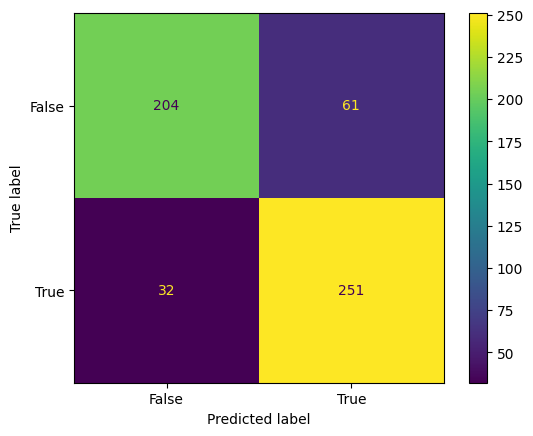

In [135]:
actual = np.random.binomial(1,.9,size = 1000)
predicted = np.random.binomial(1,.9,size = 1000)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = [False, True])

cm_display.plot()
plt.show()

In [136]:
probs = model_svm.predict_proba(list(fastext_embeddings_test))

In [137]:
malignant_probs = probs[:,1]
fpr, tpr, thresholds = roc_curve(list(labels_test), malignant_probs)
roc_auc = auc(fpr, tpr)

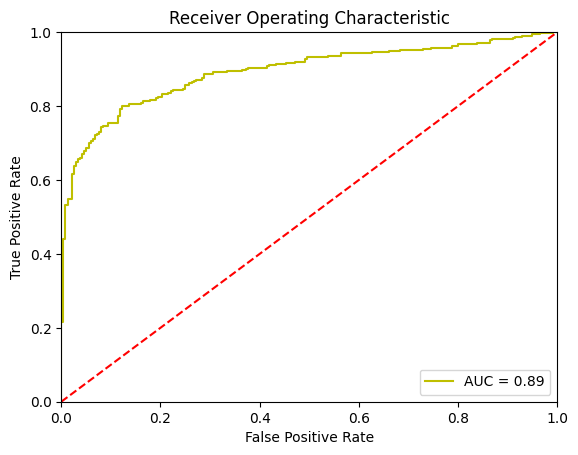

In [138]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'y', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [139]:
print("Precision Score for the data",precision_score(predictions,list(labels_test)))

Precision Score for the data 0.8044871794871795


In [140]:
print("F1 Score for the data",f1_score(predictions,list(labels_test)))

F1 Score for the data 0.8436974789915966


In [141]:
print("Recall score for the data",recall_score(predictions,list(labels_test)))

Recall score for the data 0.8869257950530035


In [142]:
print("classification report for the data\n",classification_report(predictions,list(labels_test)))

classification report for the data
               precision    recall  f1-score   support

           0       0.86      0.77      0.81       265
           1       0.80      0.89      0.84       283

    accuracy                           0.83       548
   macro avg       0.83      0.83      0.83       548
weighted avg       0.83      0.83      0.83       548



## CONTEXTUALIZED EMBEDDINGS

In [143]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [144]:
sentence_embeddings = []
for i in tqdm(range(0,len(preprocessed_data))):
  sentence_embeddings.append(sbert_model.encode(preprocessed_data.loc[i]['lemma_data']))

100%|██████████| 4380/4380 [09:01<00:00,  8.08it/s]


In [149]:
sentence_embeddings_data = pd.DataFrame(columns = ['embeddings','target'])
sentence_embeddings_data['embeddings'] = sentence_embeddings
sentence_embeddings_data['target'] = labels


In [146]:
sentence_embeddings_data

,embeddings,target
0,"[0.0930263, 0.2858388, -0.4856312, 0.048664078...",1
1,"[-0.3438824, 1.1253035, 0.11546544, -0.1990680...",1
2,"[-0.44202676, 0.3515161, -0.08311614, 0.199064...",0
3,"[-0.11771056, 1.2762864, 0.1645717, 0.17292011...",1
4,"[-0.46110377, 0.197645, -1.5401431, -0.0096881...",0
...,...,...
4375,"[-0.40098464, 0.25254604, 0.8978998, 0.2022871...",0
4376,"[-0.578963, -0.08839191, -0.04683048, 0.286064...",0
4377,"[-0.7636978, 1.1435155, -0.42331773, -0.122422...",1
4378,"[-0.18628058, 0.6886045, 0.3196819, -0.2456136...",0


In [150]:
fastext_embeddings_test = []
for i in tqdm(range(0,len(preprocessed_data_test))):
  fastext_embeddings_test.append(sbert_model.encode(preprocessed_data_test.loc[i]['lemma_data']))

100%|██████████| 548/548 [01:05<00:00,  8.40it/s]


In [173]:
model_svm = clf = SVC(kernel='rbf', C=200, gamma=1e-07, probability=True)
model_svm.fit(list(fastext_embeddings_test),list(labels_test))

SVC(C=200, gamma=1e-07, probability=True)

In [174]:
print(model_svm.score(list(fastext_embeddings_test),list(labels_test)))

0.8759124087591241


In [175]:
predictions = model_svm.predict(list(fastext_embeddings_test))

In [176]:
print("Accuracy Score for test_set :",accuracy_score(predictions,list(labels_test)))

Accuracy Score for test_set : 0.8759124087591241


In [177]:
cf = confusion_matrix(predictions,list(labels_test))

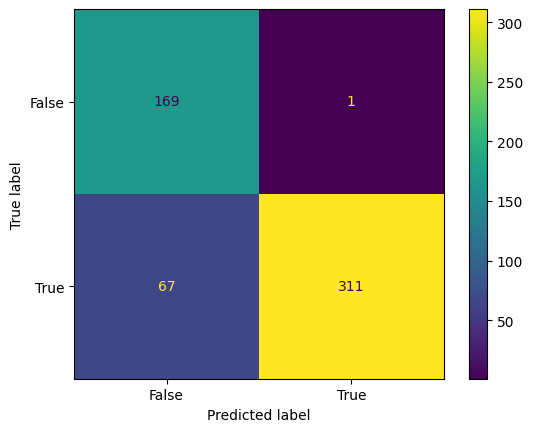

In [178]:
actual = np.random.binomial(1,.9,size = 1000)
predicted = np.random.binomial(1,.9,size = 1000)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf, display_labels = [False, True])

cm_display.plot()
plt.show()

In [179]:
probs = model_svm.predict_proba(list(fastext_embeddings_test))

In [182]:
print("Precision Score for the data",precision_score(predictions,list(labels_test)))

Precision Score for the data 0.9967948717948718


In [187]:
print("Recall Score for the data",recall_score(predictions,list(labels_test)))

Recall Score for the data 0.8227513227513228


In [183]:
print("F1 Score for the data",f1_score(predictions,list(labels_test)))

Precision Score for the data 0.9014492753623189


In [184]:
print("classification report for the data\n",classification_report(predictions,list(labels_test)))

classification report for the data
               precision    recall  f1-score   support

           0       0.72      0.99      0.83       170
           1       1.00      0.82      0.90       378

    accuracy                           0.88       548
   macro avg       0.86      0.91      0.87       548
weighted avg       0.91      0.88      0.88       548



In [185]:
Fasttext_embeddings_data.to_csv('Fasttext_embeddings_data.csv')
sentence_embeddings_data.to_csv('sentence_transformer_embeddings.csv')